# Federated MNIST multiclass classification using ConvNet

- Separate MNIST dataset by digits. 
- First server has 0-3, second 4-6, third 7-9
- By the end of federated training with averaging they all know how to correctly classify all 10 digits in the test set

In [13]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [14]:
import sys
import logging

from neoglia.workers.connect_workers import connect
from neoglia.learn.utils import setup_logging
from neoglia.learn.config import LearnConfig
from neoglia.learn.losses import cross_entropy
from neoglia.learn.models import ConvNet
from neoglia.learn.learner import Learner

In [15]:
logger = logging.getLogger()
logger.setLevel(logging.INFO)
handler = logging.StreamHandler(sys.stderr)
formatter = logging.Formatter('%(name)s - %(levelname)s - %(message)s')
handler.setFormatter(formatter)
logger.handlers = [handler]

## Connect to data nodes

In this demo, we have 3 distinct hospitals. Each is an indenpendent EC2 instance on AWS.

In [16]:
h1, h2, h3 = connect(local=True)

root - WARNING - Torch was already hooked... skipping hooking process
neoglia.workers.connect_workers - INFO - Connected to worker h1.
neoglia.workers.connect_workers - INFO - Connected to worker h2.
neoglia.workers.connect_workers - INFO - Connected to worker h3.


In [5]:
logger.info(h1.list_datasets())

root - INFO - -mnist_train:
	data size: [24754, 28, 28],
	target size: [24754]
-mnist_test:
	data size: [10000, 28, 28],
	target size: [10000]
-eicu_class_train:
	data size: [4777, 103],
	target size: [4777]
-eicu_class_test:
	data size: [5389, 103],
	target size: [5389]
-eicu_reg_train:
	data size: [4777, 103],
	target size: [4777]
-eicu_reg_test:
	data size: [5389, 103],
	target size: [5389]



Check the datasets they have and the dimensions of these.

## Train a convolutional neural network on the mnist dataset with federated averaging

Each hospital holds a subset of the training data but they all share the same test data.

## Define the config file for this experiment

This holds everything from the learning rate to the batch size. 

First let's check the available parameters. Note, this object can take a yml config file (good for reproducible experiments) or be parametrised when instantiated.

In [6]:
?LearnConfig

Init signature:
LearnConfig(
    config_file=None,
    train_dataset_name=None,
    test_dataset_name=None,
    train_batch_size=128,
    test_batch_size=128,
    train_epochs=100,
    fed_after_n_batches=10,
    metrics=['accuracy'],
    optimizer='SGD',
    optimizer_params={'lr': 0.1, 'momentum': 0.9},
    cuda=False,
    seed=42,
    save_model=True,
    verbose=True,
)
Docstring:      Config dict object, holding all parameters for the training and evaluation.
Init docstring:
Constructor of the subclassed dict object.

Args:
    config_file (str): Location of config YAML file. If provided, all
        parameters that are defined within will override the defaults here.
    train_dataset_name (str): Name of the remote dataset to train on.
    test_dataset_name (str): Name of the remote dataset to test on.
    train_batch_size (int): Batch size for training.
    test_batch_size (int): Batch size for evaluation.
    train_epochs (int): Number of epochs performed altogether for training

In [17]:
config = LearnConfig("config_mnist.yml")
config

{'config_file': 'config_mnist.yml',
 'train_dataset_name': 'mnist_train',
 'test_dataset_name': 'mnist_test',
 'train_batch_size': 128,
 'test_batch_size': 128,
 'train_epochs': 50,
 'fed_after_n_batches': 2,
 'metrics': ['accuracy', 'confusion_matrix'],
 'optimizer': 'SGD',
 'optimizer_params': {'lr': 0.1, 'momentum': 0.9},
 'cuda': False,
 'seed': 42,
 'save_model': True,
 'verbose': True,
 'regression': False}

## Define model architecture and loss function

Define a model architecture in Torch, or simply load one of NeoGlia's predefined ones.

In [18]:
model = ConvNet()

In [9]:
%psource ConvNet

class ConvNet(nn.Module):
    """
    Simple convolutional neural network for multi-class image data.

    Returns probabilities after softmax and not logits.
    """
    def __init__(self):
        super(ConvNet, self).__init__()
        self.conv1 = nn.Conv2d(1, 20, 5, 1)
        self.conv2 = nn.Conv2d(20, 50, 5, 1)
        self.fc1 = nn.Linear(4 * 4 * 50, 500)
        self.fc2 = nn.Linear(500, 10)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.max_pool2d(x, 2, 2)
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, 2, 2)
        x = x.view(-1, 4 * 4 * 50)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return F.log_softmax(x, dim=1)


We'll use cross entropy in this example as a loss function as this is a multi-class problem.

## Start training and evaluating the model in a federated manner

In [21]:
fed_learner = Learner(
    config=config,
    model=model, 
    model_input_dim=[1, 1, 28, 28],
    loss_fn=cross_entropy, 
    workers=(h1, h2, h3)
)

neoglia.learn.learner - INFO - Starting epoch 1/50
neoglia.learn.learner - INFO - Training round: 1, worker: h2, avg_loss: 1.7878
neoglia.learn.learner - INFO - Training round: 1, worker: h3, avg_loss: 1.6576
neoglia.learn.learner - INFO - Training round: 1, worker: h1, avg_loss: 1.8455
neoglia.learn.learner - INFO - Starting epoch 2/50
neoglia.learn.learner - INFO - Training round: 2, worker: h3, avg_loss: 1.0757
neoglia.learn.learner - INFO - Training round: 2, worker: h1, avg_loss: 1.5000
neoglia.learn.learner - INFO - Training round: 2, worker: h2, avg_loss: 1.1097
neoglia.learn.learner - INFO - h1: Test set: Average loss: 0.0372
neoglia.learn.utils - INFO - 	- accuracy: 0.1035


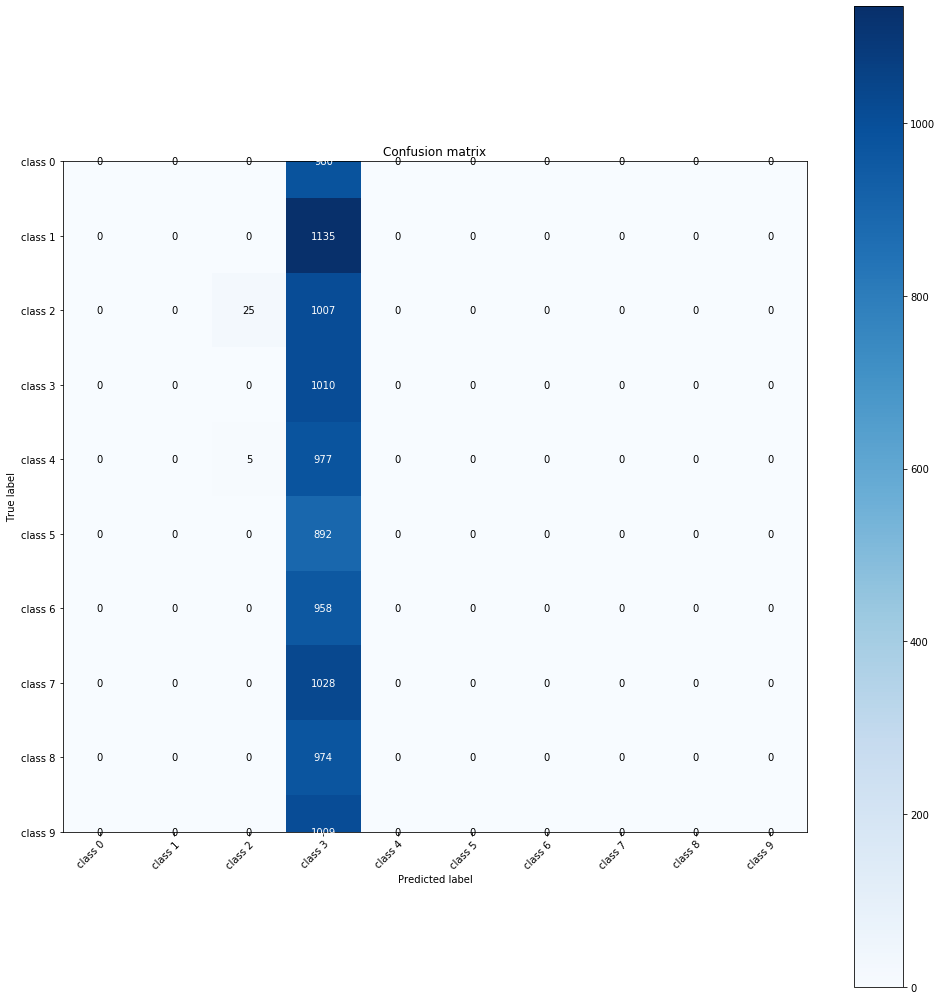

neoglia.learn.learner - INFO - h2: Test set: Average loss: 0.0644
neoglia.learn.utils - INFO - 	- accuracy: 0.0958


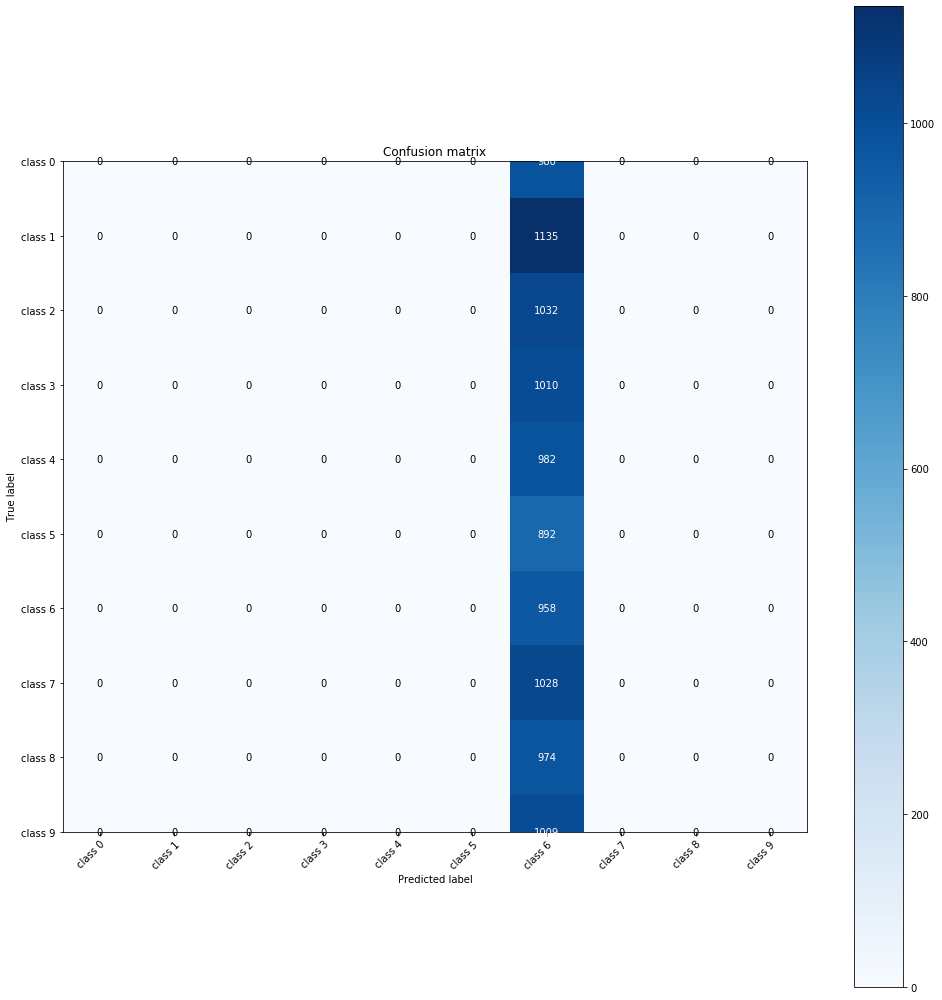

neoglia.learn.learner - INFO - h3: Test set: Average loss: 0.0785
neoglia.learn.utils - INFO - 	- accuracy: 0.1028


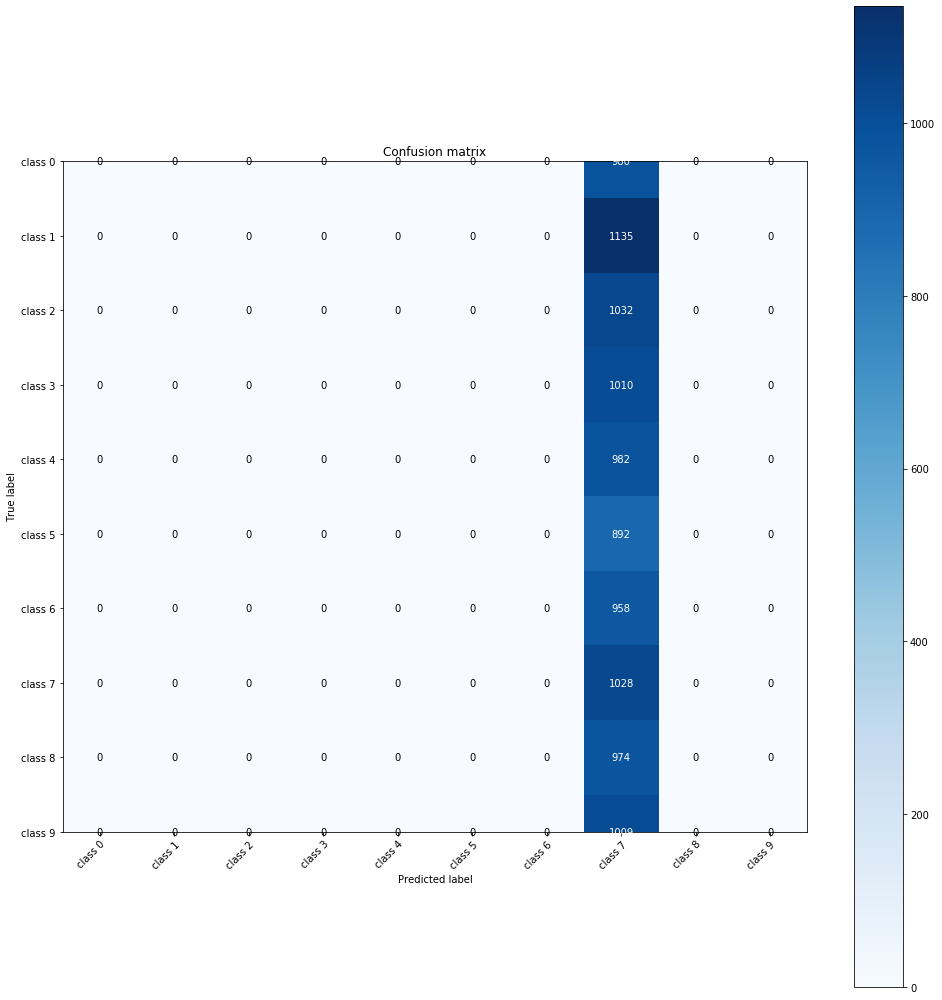

neoglia.learn.learner - INFO - Federated model: Test set: Average loss: 0.0167
neoglia.learn.utils - INFO - 	- accuracy: 0.3106


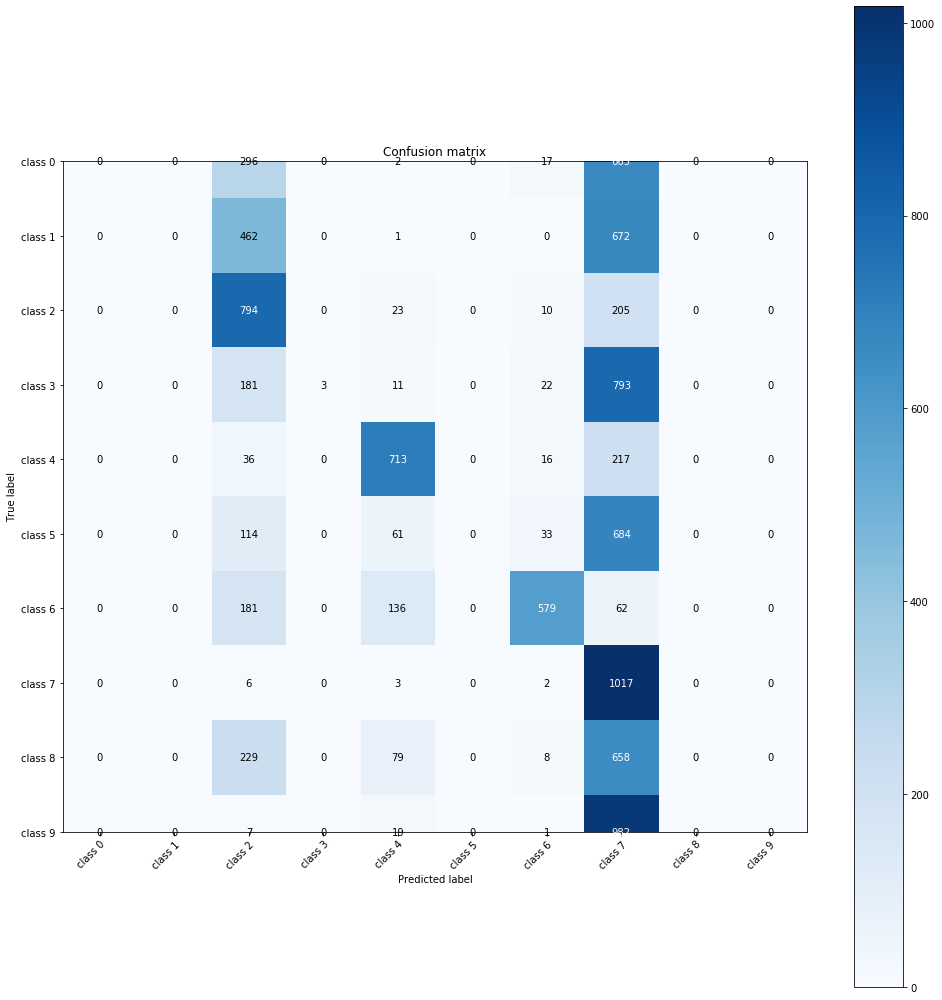

neoglia.learn.learner - INFO - Starting epoch 3/50
neoglia.learn.learner - INFO - Training round: 3, worker: h2, avg_loss: 0.9208
neoglia.learn.learner - INFO - Training round: 3, worker: h3, avg_loss: 0.9770
neoglia.learn.learner - INFO - Training round: 3, worker: h1, avg_loss: 1.1457


In [ ]:
fed_learner.train_eval()

In [12]:
for worker in (h1, h2, h3):
    worker.close()

## Load trained federated model

And test it locally on a few examples

In [20]:
import torch
m = torch.load('mnist_train_model.pt')
m

OrderedDict([('conv1.weight',
              tensor([[[[ 1.8860e-02, -1.0073e-01, -1.0674e-01,  9.7052e-03, -1.5782e-01],
                        [ 2.8249e-03,  6.3920e-03, -1.7211e-01,  9.3360e-02, -1.1974e-01],
                        [ 1.3968e-02, -1.1998e-01, -1.4551e-01,  7.7240e-02, -7.2984e-02],
                        [-2.7283e-02,  2.0283e-01,  1.5646e-01,  2.4561e-01,  1.5579e-01],
                        [-1.5279e-01, -1.0797e-01,  7.7242e-02, -6.1008e-02,  2.3347e-01]]],
              
              
                      [[[ 2.6632e-02, -5.6882e-02, -1.1255e-01, -1.1662e-01,  1.5993e-01],
                        [ 1.3329e-01, -2.0634e-01, -1.1618e-01,  1.7164e-01,  1.2429e-01],
                        [-1.7148e-01, -1.3992e-01, -7.1745e-02, -2.8118e-03,  2.0056e-01],
                        [-1.9243e-03, -9.0390e-02, -1.9782e-01,  1.2490e-01,  2.0530e-01],
                        [-1.1707e-01, -3.7539e-02, -2.7524e-02,  1.5139e-01,  2.2522e-01]]],
              
           